1. Uvoz biblioteka i podataka

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

In [2]:
df = pd.read_csv("StudentsPerformance.csv")

2. Pregled i priprema podataka

In [3]:
print(df[["gender", "test preparation course",
          "math score", "reading score", "writing score"]].head())

print("\nNedostajuće vrijednosti:")
print(df.isnull().sum())

   gender test preparation course  math score  reading score  writing score
0  female                    none          72             72             74
1  female               completed          69             90             88
2  female                    none          90             95             93
3    male                    none          47             57             44
4    male                    none          76             78             75

Nedostajuće vrijednosti:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


Iz ovog ispisa vidiljivo je da odabrani stupci nemaju nedostajućih vrijednosti što znači da ne trebamo koristiti mjere nadomještanja ili brisanja podataka.

3. Provjera pretpostavki MANOVA

In [4]:
for col in ["math score", "reading score", "writing score"]:
    stat, p = stats.shapiro(df[col])
    print(f"{col}: W={stat:.3f}, p={p:.5f}")

math score: W=0.993, p=0.00015
reading score: W=0.993, p=0.00011
writing score: W=0.992, p=0.00003


Shapiro–Wilk test pokazao je statistički značajna odstupanja od normalne razdiobe (p < 0.05).

S obzirom na veličinu uzorka i robusnost MANOVA metode, analiza se smatra opravdanom.

In [6]:
corr = df[["math score", "reading score", "writing score"]].corr()
print(corr)

               math score  reading score  writing score
math score       1.000000       0.817580       0.802642
reading score    0.817580       1.000000       0.954598
writing score    0.802642       0.954598       1.000000


Prije provođenja MANOVE, dobro je provjeriti korelaciju između zavisnih varijabli jer opravdava multivarijatni pristup.

Kao što se vidi iz rezultata, imamo umjerene do jake korelacije između varijabli.

4. Provedba dvofaktorske MANOVA

In [7]:
maov = MANOVA.from_formula(
    'Q("math score") + Q("reading score") + Q("writing score") ~ gender * Q("test preparation course")',
    data=df
)

print(maov.mv_test())

                        Multivariate linear model
                                                                          
----------------------------------------------------------------------------
          Intercept          Value    Num DF    Den DF     F Value    Pr > F
----------------------------------------------------------------------------
             Wilks' lambda   0.1282   3.0000   994.0000   2253.3361   0.0000
            Pillai's trace   0.8718   3.0000   994.0000   2253.3361   0.0000
    Hotelling-Lawley trace   6.8008   3.0000   994.0000   2253.3361   0.0000
       Roy's greatest root   6.8008   3.0000   994.0000   2253.3361   0.0000
--------------------------------------------------------------------------
                                                                          
----------------------------------------------------------------------------
             gender           Value    Num DF    Den DF    F Value    Pr > F
--------------------------------

5. Interpretacija MANOVA rezultata

0. Intercept

Intercept testira je li vektor srednjih vrijednosti različit od nule

U kontekstu MANOVA se NE interpretira sadržajno

1. Glavni efekt spola (gender)

Wilks’ lambda = 0.653, vrijednost značajno manja od 1, ukazuje na razlike između spolova u multivarijatnom prostoru

p < 0.001

razlika je statistički značajna

Postoji statistički značajan multivarijatni efekt spola učenika na kombinaciju zavisnih varijabli (math, reading i writing score).

dječaci i djevojčice se razlikuju u ukupnom profilu akademskih postignuća

2. Glavni efekt pripremnog tečaja (test preparation course)

Wilks’ lambda = 0.885, bliže 1 nego kod spola, ali i dalje ukazuje na značajan efekt

p < 0.001

efekt je statistički značajan

Pohađanje pripremnog tečaja ima statistički značajan multivarijatni utjecaj na rezultate iz matematike, čitanja i pisanja.

Efekt je manji nego kod spola, ali i dalje važan.

3. Interakcijski efekt (gender × test preparation course)

Wilks’ lambda ≈ 1, gotovo nikakve razlike među kombinacijama skupina

p = 0.9535

daleko iznad 0.05

Ne postoji statistički značajan interakcijski efekt između spola učenika i pohađanja pripremnog tečaja.

-Rezultati MANOVA analize, temeljeni na Wilksovoj lambda statistici, pokazali su statistički značajan multivarijatni efekt spola učenika (Λ = 0.653, p < 0.001) te pohađanja pripremnog tečaja (Λ = 0.885, p < 0.001) na kombinaciju zavisnih varijabli. Interakcijski efekt spola i pripremnog tečaja nije bio statistički značajan (Λ = 0.9997, p = 0.954). Dobiveni rezultati ukazuju da spol i pripremni tečaj neovisno utječu na obrazovna postignuća učenika.

6. Univarijatne dvofaktorske ANOVA

In [ ]:
model_math = ols(
    'Q("math score") ~ gender * Q("test preparation course")',
    data=df
).fit()

print(sm.stats.anova_lm(model_math, typ=2))

                                            sum_sq     df          F  \
gender                                 6399.209637    1.0  29.502577   
Q("test preparation course")           7170.996015    1.0  33.060780   
gender:Q("test preparation course")       0.907979    1.0   0.004186   
Residual                             216035.801152  996.0        NaN   

                                           PR(>F)  
gender                               7.018859e-08  
Q("test preparation course")         1.187245e-08  
gender:Q("test preparation course")  9.484258e-01  
Residual                                      NaN  


Univarijatna dvofaktorska ANOVA – math score

Rezultati
Efekt	F	p
gender	29.50	p < 0.001
test preparation course	33.06	p < 0.001
gender × test prep	0.00	p = 0.948

Interpretacija

Glavni efekt spola je statistički značajan

Postoje značajne razlike u rezultatima iz matematike između dječaka i djevojčica.

Glavni efekt pripremnog tečaja je statistički značajan

Učenici koji su pohađali pripremni tečaj ostvaruju značajno bolje rezultate iz matematike.

Interakcijski efekt nije značajan

Učinak pripremnog tečaja je sličan za oba spola.

Spol ne modificira utjecaj pripremnog tečaja na math score.

Gotova rečenica za rad

Univarijatna ANOVA analiza pokazala je statistički značajan glavni efekt spola i pohađanja pripremnog tečaja na rezultate iz matematike, dok interakcijski efekt nije bio značajan.



In [ ]:
model_reading = ols(
    'Q("reading score") ~ gender * Q("test preparation course")',
    data=df
).fit()

print(sm.stats.anova_lm(model_reading, typ=2))

                                            sum_sq     df          F  \
gender                                12863.415867    1.0  68.279387   
Q("test preparation course")          12601.298604    1.0  66.888061   
gender:Q("test preparation course")       0.033683    1.0   0.000179   
Residual                             187640.263036  996.0        NaN   

                                           PR(>F)  
gender                               4.491478e-16  
Q("test preparation course")         8.697155e-16  
gender:Q("test preparation course")  9.893342e-01  
Residual                                      NaN  


Univarijatna dvofaktorska ANOVA – reading score

Rezultati
Efekt	F	p
gender	68.28	p < 0.001
test preparation course	66.89	p < 0.001
gender × test prep	0.00	p = 0.989

Interpretacija

Spol ima snažan i statistički značajan efekt

Razlike između dječaka i djevojčica u čitanju su izraženije nego u matematici.

Pripremni tečaj ima snažan statistički značajan efekt

Učenici koji su pohađali tečaj postižu znatno bolje rezultate u čitanju.

Interakcija nije značajna

Efekt pripremnog tečaja ne ovisi o spolu.

Gotova rečenica za rad

Rezultati univarijatne ANOVA analize ukazuju na izražen statistički značajan utjecaj spola i pohađanja pripremnog tečaja na reading score, bez značajnog interakcijskog djelovanja.

In [ ]:
model_writing = ols(
    'Q("writing score") ~ gender * Q("test preparation course")',
    data=df
).fit()

print(sm.stats.anova_lm(model_writing, typ=2))

                                            sum_sq     df           F  \
gender                                21194.572529    1.0  112.956231   
Q("test preparation course")          22855.197297    1.0  121.806511   
gender:Q("test preparation course")       6.338306    1.0    0.033780   
Residual                             186884.725984  996.0         NaN   

                                           PR(>F)  
gender                               4.578510e-25  
Q("test preparation course")         8.455267e-27  
gender:Q("test preparation course")  8.542131e-01  
Residual                                      NaN  


Univarijatna dvofaktorska ANOVA – writing score

Rezultati
Efekt	F	p
gender	112.96	p < 0.001
test preparation course	121.81	p < 0.001
gender × test prep	0.03	p = 0.854

Interpretacija

Vrlo snažan glavni efekt spola

Razlike između dječaka i djevojčica su najveće upravo u pisanju.

Vrlo snažan efekt pripremnog tečaja

Pripremni tečaj ima najveći utjecaj upravo na writing score.

Interakcija nije značajna

Spol i pripremni tečaj djeluju neovisno jedan o drugome.

Gotova rečenica za rad

Univarijatna analiza pokazala je vrlo snažan statistički značajan efekt spola i pripremnog tečaja na writing score, dok interakcijski efekt nije bio statistički značajan.

Statistička značajnost procjenjivana je na temelju p-vrijednosti očitanih iz stupca PR(>F) u ANOVA tablici.

Kada faktor ima samo dvije razine, F-test u ANOVA analizi ekvivalentan je t-testu te dodatni post-hoc testovi nisu potrebni.

7. Grafička interpretacija

In [ ]:
#Srednje vrijednosti po faktorima

means = df.groupby(["gender", "test preparation course"])[
    ["math score", "reading score", "writing score"]
].mean()

print(means)


                                math score  reading score  writing score
gender test preparation course                                          
female completed                 67.195652      77.375000      78.793478
       none                      61.670659      69.982036      68.982036
male   completed                 72.339080      70.212644      69.793103
       none                      66.688312      62.795455      59.649351


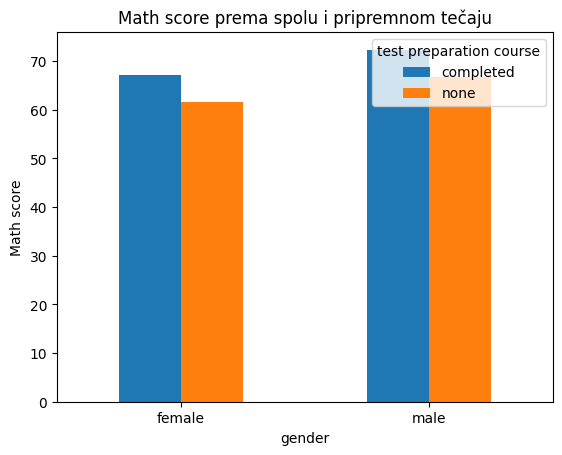

In [ ]:
means_math = df.groupby(["gender", "test preparation course"])["math score"].mean()

means_math.unstack().plot(kind="bar")
plt.ylabel("Math score")
plt.title("Math score prema spolu i pripremnom tečaju")
plt.xticks(rotation=0)
plt.show()